In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import sem
import time
%matplotlib inline
%config Completer.use_jedi = False


#import required sklearn for random forest classifier

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,roc_auc_score, f1_score, make_scorer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold, cross_validate
from sklearn.feature_selection import mutual_info_classif,VarianceThreshold, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
#Import FPKM data for all cancer types

all_cancer_file = '/Users/jake/OneDrive - University of Glasgow/Project/Cancer Stratification/all_cancers_SS_filtered.csv'
all_cancers = pd.read_csv(all_cancer_file,header=[0,1],sep='\t',index_col=[0])

In [3]:
all_cancers

Gene_symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,Cancer_tissue_status
Gene_ensembl_id,ENSG00000121410,ENSG00000148584,ENSG00000175899,ENSG00000166535,ENSG00000184389,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,ENSG00000114771,...,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755,Cancer_tissue_status
TCGA-BH-A1FN,0.208011,0.009381,43.292960,0.055509,0.110075,3.581380,0.038150,5.007168,1.640055,0.000000,...,4.351933,24.207158,1.127985,3.549771,7.245900,2.346176,12.914487,41.879917,3.253812,BRCA_1
TCGA-E9-A1NG,0.108386,0.004110,178.373384,0.327900,0.000000,7.944528,0.022288,7.198746,2.232691,0.000000,...,4.018591,7.967490,0.985287,2.102866,2.553868,0.058864,6.947852,67.347728,2.725455,BRCA_1
TCGA-AC-A23H,0.020294,0.002822,37.866925,0.395196,0.000000,1.740345,0.007651,8.431803,6.124952,0.032494,...,3.705314,20.387417,1.722966,7.227800,7.604626,0.825575,6.627812,70.866135,5.747454,BRCA_1
TCGA-A7-A0DC,0.660110,0.131949,55.782077,0.746827,0.269265,1.928116,0.217754,9.173075,4.806061,1.023887,...,2.624497,2.756902,2.866430,6.842064,14.519888,0.246469,6.343812,17.736301,17.258228,BRCA_1
TCGA-BH-A0BA,0.146119,0.014777,123.459875,0.240457,0.000000,3.357131,0.040063,10.716496,23.238758,0.510444,...,6.127255,20.796211,2.328833,5.314763,4.388074,1.277253,6.348272,45.638784,5.031597,BRCA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3T6,0.166550,0.004737,46.248647,0.031145,0.088936,4.158023,0.051373,8.959670,2.018176,0.172727,...,1.688672,2.863111,1.563187,3.586380,4.987906,0.888369,5.081061,124.884518,4.719659,THCA_0
TCGA-EM-A1CT,0.095714,0.000000,38.841957,0.015557,0.083291,5.891831,0.000000,8.641519,2.370101,0.025542,...,1.686923,3.033729,1.905922,3.987611,4.574804,1.098218,7.802169,14.486686,4.200076,THCA_0
TCGA-EM-A1CU,0.027703,0.005778,36.442801,0.035458,0.000000,2.344291,0.135774,7.603383,2.085959,0.022178,...,1.659320,4.091353,2.603832,5.334968,5.488403,2.151506,12.835744,15.766241,4.772690,THCA_0


In [4]:
#Load all isoform switch csvs for all cancer types 

BRCA_isoform_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/isoform_switch/BRCA_isoform_switches_ensembl.csv'
KIRC_isoform_file = '/Users/jake/OneDrive - University of Glasgow/Project/KIRC/isoform_switch/KIRC_isoform_switches_ensembl.csv'
LUAD_isoform_file = '/Users/jake/OneDrive - University of Glasgow/Project/LUAD/isoform_switch/LUAD_isoform_switches_ensembl.csv'
THCA_isoform_file = '/Users/jake/OneDrive - University of Glasgow/Project/THCA/isoform_switch/THCA_isoform_switches_ensembl.csv'

BRCA_isoform = pd.read_csv(BRCA_isoform_file,sep='\t')
KIRC_isoform = pd.read_csv(KIRC_isoform_file,sep='\t')
LUAD_isoform = pd.read_csv(LUAD_isoform_file,sep='\t')
THCA_isoform = pd.read_csv(THCA_isoform_file,sep='\t')

In [5]:
#Load pancan isoform switch csv for all cancer types 

pancan_isoform_file = '/Users/jake/OneDrive - University of Glasgow/Project/Isoform Data/pancan_isoforms_SS.csv'

pancan_isoform = pd.read_csv(pancan_isoform_file,sep='\t',index_col=0)

In [6]:
#Check for missing values

all_cancers.isnull().sum().sort_values(ascending=False)

Gene_symbol           Gene_ensembl_id     
A1BG                  ENSG00000121410         0
PPP1R9A               ENSG00000158528         0
PPP2R2B               ENSG00000156475         0
PPP2R2A               ENSG00000221914         0
PPP2R1B               ENSG00000137713         0
                                             ..
GBP6                  ENSG00000183347         0
GBP5                  ENSG00000154451         0
GBP4                  ENSG00000162654         0
GBP3                  ENSG00000117226         0
Cancer_tissue_status  Cancer_tissue_status    0
Length: 19536, dtype: int64

In [7]:
#Perform a PCA to see if any global difference at gene expression level between the cancer and tissue types

#First split data into features and target
X_full = all_cancers.drop(['Cancer_tissue_status','Cancer_tissue_status'],axis=1,level=0)
y_full = all_cancers['Cancer_tissue_status','Cancer_tissue_status']

#Then need to scale data
X_pca_full = StandardScaler().fit_transform(X_full.values)

X_pca_df_full = pd.DataFrame(X_pca_full, index=X_full.index, columns=X_full.columns)

#Now create 2 component PCA

pca = PCA(n_components=2)
principal_comp_full = pca.fit_transform(X_pca_df_full)
pca_df_full = pd.DataFrame(data = principal_comp_full, columns = ['PC 1', 'PC 2'],index=X_full.index)

#Now concat the pca_df with the target cancer col
final_pca_df_full = pd.concat([pca_df_full, y_full], axis = 1)
final_pca_df_full

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,57.254136,-41.049758,BRCA_1
TCGA-E9-A1NG,8.069507,-8.413137,BRCA_1
TCGA-AC-A23H,31.328146,-47.987579,BRCA_1
TCGA-A7-A0DC,227.189724,-1.634858,BRCA_1
TCGA-BH-A0BA,50.506233,-35.341717,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-22.808406,-13.800685,THCA_0
TCGA-EM-A1CT,-18.936406,-12.003263,THCA_0
TCGA-EM-A1CU,15.246220,6.017832,THCA_0
TCGA-BJ-A2N9,-34.957498,-27.745813,THCA_0


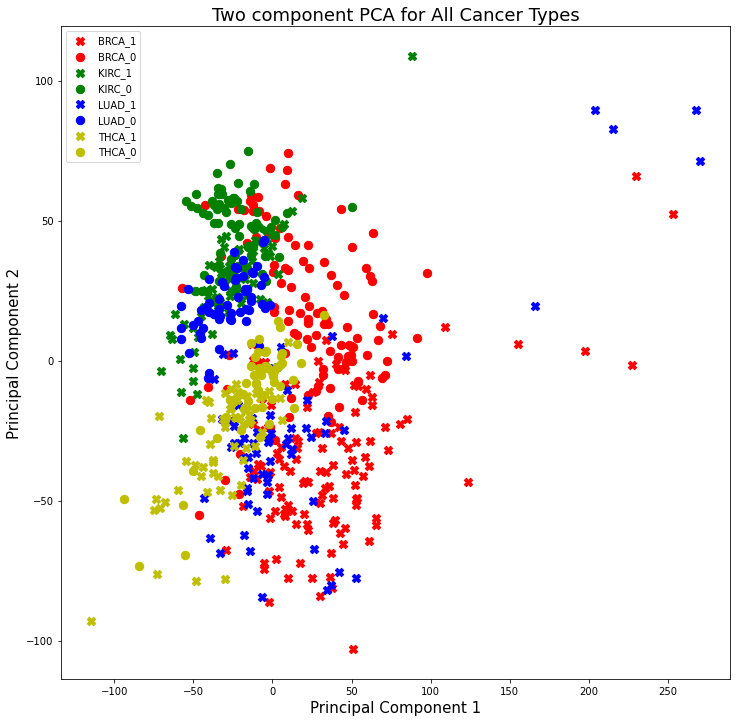

In [39]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between cancer and tissue types when matched

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types', fontsize = 18)
targets = list(final_pca_df_full[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_full[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_full.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_full.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_full[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_full.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_full.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [8]:
#Now look at PCA for isoform filtered, both unique and pancan

#Concat all the different isoform switch data into one dataframe

isoform_switches = pd.concat([BRCA_isoform,KIRC_isoform,LUAD_isoform,THCA_isoform]).reset_index()

isoform_switches

,index,Gene_symbol,ensembl_gene_id,entrezgene_id,chromosome_name
0,1,TANK,ENSG00000136560,10010,2
1,2,RBCK1,ENSG00000125826,10616,20
2,3,GOLM2,ENSG00000166734,113201,15
3,4,DUT,ENSG00000128951,1854,15
4,5,TMEM201,ENSG00000188807,199953,1
...,...,...,...,...,...
174,21,S100A13,ENSG00000189171,6284,1
175,22,LINC01184,ENSG00000245937,644873,5
176,23,SNAPC3,ENSG00000164975,6619,9
177,24,SOS2,ENSG00000100485,6655,14


In [9]:
#Drop any duplicated genes in the ensembl_gene_id column

isoform_unique = isoform_switches.drop_duplicates('ensembl_gene_id')

In [10]:
isoform_unique['Gene_symbol'].nunique()

159

In [11]:
#Now filter the genes / columns in X_matched in relation to unique the isoform switches

X_iso_unique = X_full.loc(axis=1)[:, list(isoform_unique['ensembl_gene_id'])]

In [12]:
#Now try a PCA on the isform filtered, matched data to see if increases the variance between the dif cancer types

X_pca_iso_unique = StandardScaler().fit_transform(X_iso_unique.values)

X_pca_df_iso_unique = pd.DataFrame(X_pca_iso_unique, index=X_iso_unique.index, columns=X_iso_unique.columns)

pca_iso_unique = PCA(n_components=2)

principal_comp_iso_unique = pca_iso_unique.fit_transform(X_pca_df_iso_unique)

pca_df_iso_unique = pd.DataFrame(data = principal_comp_iso_unique, columns = ['PC 1', 'PC 2'],index=X_iso_unique.index)

final_pca_df_iso_unique = pd.concat([pca_df_iso_unique, y_full], axis = 1)
final_pca_df_iso_unique

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,4.954585,-4.427724,BRCA_1
TCGA-E9-A1NG,0.800390,-2.444030,BRCA_1
TCGA-AC-A23H,1.941365,-4.344318,BRCA_1
TCGA-A7-A0DC,15.661797,-7.125081,BRCA_1
TCGA-BH-A0BA,3.074997,-3.814996,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-2.311682,-1.648216,THCA_0
TCGA-EM-A1CT,-2.709770,0.192030,THCA_0
TCGA-EM-A1CU,1.012162,1.036944,THCA_0
TCGA-BJ-A2N9,-4.940647,-0.757396,THCA_0


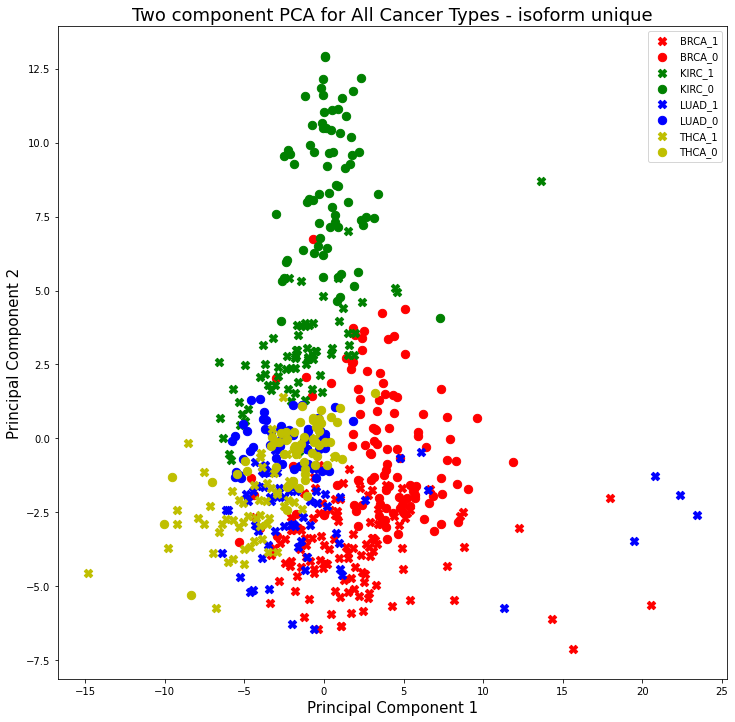

In [45]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between iso_uniqueform filtered

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - isoform unique', fontsize = 18)
targets = list(final_pca_df_iso_unique[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_iso_unique[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_iso_unique.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_iso_unique.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_iso_unique[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_iso_unique.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_iso_unique.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [13]:
#Now do PCA with pancan isoforms


In [14]:
pancan_isoform.reset_index(drop=True,inplace=True)

In [15]:
pancan_isoform.nunique()


Gene_symbol        18
ensembl_gene_id    18
dtype: int64

In [16]:
#Now can drop the duplicated instances of genes in the pancan to filter all cancer later

pancan_isoform.drop_duplicates(inplace=True)

In [17]:
pancan_isoform.nunique()

Gene_symbol        18
ensembl_gene_id    18
dtype: int64

In [18]:
#Now filter the genes / columns in X_matched in relation to the isoform switches

X_iso_pancan = X_full.loc(axis=1)[:, list(pancan_isoform['ensembl_gene_id'])]

In [19]:
#Now try a PCA 

X_pca_iso_pancan = StandardScaler().fit_transform(X_iso_pancan.values)

X_pca_df_iso_pancan = pd.DataFrame(X_pca_iso_pancan, index=X_iso_pancan.index, columns=X_iso_pancan.columns)

pca_iso_pancan = PCA(n_components=2)

principal_comp_iso_pancan = pca_iso_pancan.fit_transform(X_pca_df_iso_pancan)

pca_df_iso_pancan = pd.DataFrame(data = principal_comp_iso_pancan, columns = ['PC 1', 'PC 2'],index=X_iso_pancan.index)

final_pca_df_iso_pancan = pd.concat([pca_df_iso_pancan, y_full], axis = 1)
final_pca_df_iso_pancan

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,-0.049900,2.072561,BRCA_1
TCGA-E9-A1NG,0.256307,-0.261604,BRCA_1
TCGA-AC-A23H,-1.988569,0.342020,BRCA_1
TCGA-A7-A0DC,1.295409,3.373386,BRCA_1
TCGA-BH-A0BA,-0.623473,0.733535,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-0.765585,-0.582902,THCA_0
TCGA-EM-A1CT,-0.537696,0.242979,THCA_0
TCGA-EM-A1CU,-1.607221,0.936111,THCA_0
TCGA-BJ-A2N9,-0.873194,-1.648641,THCA_0


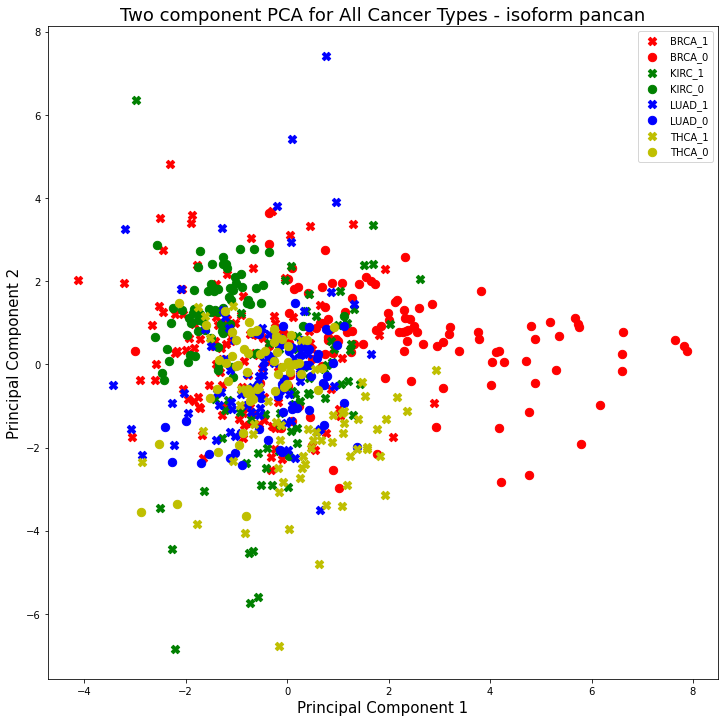

In [53]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between iso_pancanform filtered

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - isoform pancan', fontsize = 18)
targets = list(final_pca_df_iso_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_iso_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_iso_pancan.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_iso_pancan.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_iso_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_iso_pancan.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_iso_pancan.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [54]:
#Now for modelling - using RF since LogRed struggled with convergance 

In [20]:
#First do label encoding of the target y column

#Make copy of all_cancer

all_cancers_encoded = all_cancers.copy()

le = LabelEncoder()

all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status'] = le.fit_transform(all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status'])
all_cancers_encoded

X_encoded = all_cancers_encoded.drop('Cancer_tissue_status',axis=1,level=0)
X_encoded_iso_unique = X_encoded.loc(axis=1)[:, list(isoform_unique['ensembl_gene_id'])]
X_encoded_iso_pancan = X_encoded.loc(axis=1)[:, list(pancan_isoform['ensembl_gene_id'])]

y_encoded = all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status']

In [21]:
#Create dictionary to see lables created for label encoding

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'BRCA_0': 0,
 'BRCA_1': 1,
 'KIRC_0': 2,
 'KIRC_1': 3,
 'LUAD_0': 4,
 'LUAD_1': 5,
 'THCA_0': 6,
 'THCA_1': 7}

In [22]:
all_cancers_encoded

Gene_symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,Cancer_tissue_status
Gene_ensembl_id,ENSG00000121410,ENSG00000148584,ENSG00000175899,ENSG00000166535,ENSG00000184389,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,ENSG00000114771,...,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755,Cancer_tissue_status
TCGA-BH-A1FN,0.208011,0.009381,43.292960,0.055509,0.110075,3.581380,0.038150,5.007168,1.640055,0.000000,...,4.351933,24.207158,1.127985,3.549771,7.245900,2.346176,12.914487,41.879917,3.253812,1
TCGA-E9-A1NG,0.108386,0.004110,178.373384,0.327900,0.000000,7.944528,0.022288,7.198746,2.232691,0.000000,...,4.018591,7.967490,0.985287,2.102866,2.553868,0.058864,6.947852,67.347728,2.725455,1
TCGA-AC-A23H,0.020294,0.002822,37.866925,0.395196,0.000000,1.740345,0.007651,8.431803,6.124952,0.032494,...,3.705314,20.387417,1.722966,7.227800,7.604626,0.825575,6.627812,70.866135,5.747454,1
TCGA-A7-A0DC,0.660110,0.131949,55.782077,0.746827,0.269265,1.928116,0.217754,9.173075,4.806061,1.023887,...,2.624497,2.756902,2.866430,6.842064,14.519888,0.246469,6.343812,17.736301,17.258228,1
TCGA-BH-A0BA,0.146119,0.014777,123.459875,0.240457,0.000000,3.357131,0.040063,10.716496,23.238758,0.510444,...,6.127255,20.796211,2.328833,5.314763,4.388074,1.277253,6.348272,45.638784,5.031597,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3T6,0.166550,0.004737,46.248647,0.031145,0.088936,4.158023,0.051373,8.959670,2.018176,0.172727,...,1.688672,2.863111,1.563187,3.586380,4.987906,0.888369,5.081061,124.884518,4.719659,6
TCGA-EM-A1CT,0.095714,0.000000,38.841957,0.015557,0.083291,5.891831,0.000000,8.641519,2.370101,0.025542,...,1.686923,3.033729,1.905922,3.987611,4.574804,1.098218,7.802169,14.486686,4.200076,6
TCGA-EM-A1CU,0.027703,0.005778,36.442801,0.035458,0.000000,2.344291,0.135774,7.603383,2.085959,0.022178,...,1.659320,4.091353,2.603832,5.334968,5.488403,2.151506,12.835744,15.766241,4.772690,6


In [23]:
#Now do train test splits

X_develop_full, X_test_full, y_develop_full, y_test_full = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42,stratify=y_encoded)

X_develop_iso_unique, X_test_iso_unique, y_develop_iso_unique, y_test_iso_unique = train_test_split(X_encoded_iso_unique, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)
X_develop_iso_pancan, X_test_iso_pancan, y_develop_iso_pancan, y_test_iso_pancan = train_test_split(X_encoded_iso_pancan, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)

In [24]:
#Also take a random sample of genes .. same num as unique and pancan

X_random_unique_1 = X_encoded.sample(n=len(X_encoded_iso_unique.columns),axis=1)
X_random_unique_2 = X_encoded.sample(n=len(X_encoded_iso_unique.columns),axis=1)
X_random_unique_3 = X_encoded.sample(n=len(X_encoded_iso_unique.columns),axis=1)

X_develop_iso_unique_ran_1, X_test_iso_unique_ran_1, y_develop_iso_unique_ran_1, y_test_iso_unique_ran_1 = train_test_split(X_random_unique_1, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)
X_develop_iso_unique_ran_2, X_test_iso_unique_ran_2, y_develop_iso_unique_ran_2, y_test_iso_unique_ran_2 = train_test_split(X_random_unique_2, y_encoded, test_size=0.3, random_state=2,stratify=y_encoded)
X_develop_iso_unique_ran_3, X_test_iso_unique_ran_3, y_develop_iso_unique_ran_3, y_test_iso_unique_ran_3 = train_test_split(X_random_unique_3, y_encoded, test_size=0.3, random_state=3,stratify=y_encoded)


In [25]:
#Pancan random

X_random_pancan_1 = X_encoded.sample(n=len(X_encoded_iso_pancan.columns),axis=1)
X_random_pancan_2 = X_encoded.sample(n=len(X_encoded_iso_pancan.columns),axis=1)
X_random_pancan_3 = X_encoded.sample(n=len(X_encoded_iso_pancan.columns),axis=1)

X_develop_iso_pancan_ran_1, X_test_iso_pancan_ran_1, y_develop_iso_pancan_ran_1, y_test_iso_pancan_ran_1 = train_test_split(X_random_pancan_1, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)
X_develop_iso_pancan_ran_2, X_test_iso_pancan_ran_2, y_develop_iso_pancan_ran_2, y_test_iso_pancan_ran_2 = train_test_split(X_random_pancan_2, y_encoded, test_size=0.3, random_state=2,stratify=y_encoded)
X_develop_iso_pancan_ran_3, X_test_iso_pancan_ran_3, y_develop_iso_pancan_ran_3, y_test_iso_pancan_ran_3 = train_test_split(X_random_pancan_1, y_encoded, test_size=0.3, random_state=2,stratify=y_encoded)




In [26]:
X_random_pancan_1

Gene_symbol,RAB29,CATSPER1,VSIG1,IMPA2,PFAS,ZNF546,CD226,TENT4B,POTEB2,CDCA7L,P2RY12,LCE3D,KDM3A,HSPB7,NFXL1,NAMPT,UNC80,CST6
Gene_ensembl_id,ENSG00000117280,ENSG00000175294,ENSG00000101842,ENSG00000141401,ENSG00000178921,ENSG00000187187,ENSG00000150637,ENSG00000121274,ENSG00000230031,ENSG00000164649,ENSG00000169313,ENSG00000163202,ENSG00000115548,ENSG00000173641,ENSG00000170448,ENSG00000105835,ENSG00000144406,ENSG00000175315
TCGA-BH-A1FN,16.174544,0.192777,0.758879,9.585566,3.184524,0.697620,0.275779,3.520347,0.0,10.276688,0.048459,0.073479,5.444524,0.967670,5.765953,15.632305,0.002339,4.035450
TCGA-E9-A1NG,6.605827,0.690434,0.139638,1.430977,4.032016,0.584320,0.121560,1.628522,0.0,1.940995,1.104120,0.429280,6.775246,1.167679,2.338641,12.478398,0.007515,39.073566
TCGA-AC-A23H,6.251349,0.045385,0.208514,2.348637,2.745143,0.176011,0.070541,2.059760,0.0,4.932350,0.349861,0.000000,6.824881,0.602985,3.450915,15.491933,0.001407,9.907976
TCGA-A7-A0DC,2.895082,0.061509,0.116936,8.180938,11.246506,3.394681,0.428195,1.853527,0.0,2.434096,1.718837,0.000000,16.811117,2.536191,7.728074,7.007465,0.020025,0.653261
TCGA-BH-A0BA,13.918027,0.092420,1.011849,5.258779,5.224621,0.764108,0.377182,2.291296,0.0,1.772053,0.667916,0.000000,5.198620,2.685643,2.757214,24.596721,0.001842,0.303812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3T6,12.097324,0.169300,0.128744,10.838538,2.683105,0.395632,0.376923,3.690367,0.0,4.392023,0.570982,0.000000,6.893285,6.631671,2.444986,8.918215,0.093700,23.294877
TCGA-EM-A1CT,20.903046,0.021141,0.037679,8.587546,2.655454,0.793072,0.055189,2.378491,0.0,7.016938,0.160422,0.000000,3.470157,3.624755,3.053067,3.968927,0.069317,14.407009
TCGA-EM-A1CU,17.915352,0.061954,0.049076,8.235240,2.726905,1.396438,0.188520,4.049549,0.0,16.249265,1.482518,0.000000,6.885775,0.676476,6.125674,5.292057,0.163279,12.940343


In [27]:
#First do simple Random Forest with gridsearch to determine optimal parameters

def grid_search_RF(X,y):
    '''Perform Random Forest grid search. Supply development X and y data.'''

    #Random Forest
    classifier = RandomForestClassifier()
    
    #Want to add PCA to pipeline .. use up to 10 components
    pca = PCA(n_components=10)

    #Pipeline containing Log Reg classifier and Log Reg with deafault settings for feature engineering
    #Also added scaler as error related to iterations / convergance appears, which can be due to 'poor scaling'
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',pca),
                                  ('feature_selection', SelectFromModel(RandomForestClassifier())),
                                  ('classifier',classifier)])


    
    #The PCA searches from 1 upto max number of features / genes in 5 steps (since can't search PC's more than max num of features)
    param_grid = {
                'classifier__n_estimators': [50,100,200,300]
                'classifier__max_features': ['auto', 'sqrt', 'log2'],
                #'classifier__criterion' :['gini', 'entropy'],

    }


    #Use repeated stratified k fold to maintian ratio between tumor and normal and do multliple splits of data
    r_stratkfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

    #scoring =  roc_auc_ovr since multitarget and ovr accounts for any class imbalance
    grid_search = GridSearchCV(RF_pipeline, param_grid=param_grid, scoring="roc_auc_ovr",cv=r_stratkfold)

    #Fit on development data
    grid_search.fit(X, y)
    
    #Create dictinoary to store the best parameters
    best_params = {}
    
    for k,v in grid_search.best_params_.items():
        
        best_params[k] = v
 
    #Return the best_params dictinoary => run this fuction and save as new variable in relation to what X and y run
    return best_params

In [28]:
best_params_iso_unqiue = grid_search_RF(X_develop_iso_unique,y_develop_iso_unique)
best_params_iso_unqiue

{'classifier__n_estimators': 200}

In [29]:
best_params_iso_unique_ran_1 = grid_search_RF(X_develop_iso_unique_ran_1,y_develop_iso_unique_ran_1)
best_params_iso_unique_ran_2 = grid_search_RF(X_develop_iso_unique_ran_2,y_develop_iso_unique_ran_2)
best_params_iso_unique_ran_3 = grid_search_RF(X_develop_iso_unique_ran_3,y_develop_iso_unique_ran_3)

In [30]:
best_params_iso_pancan = grid_search_RF(X_develop_iso_pancan,y_develop_iso_pancan)
best_params_iso_pancan

{'classifier__n_estimators': 200}

In [31]:
best_params_iso_pancan_ran_1 = grid_search_RF(X_develop_iso_pancan_ran_1,y_develop_iso_pancan_ran_1)
best_params_iso_pancan_ran_2 = grid_search_RF(X_develop_iso_pancan_ran_2,y_develop_iso_pancan_ran_2)
best_params_iso_pancan_ran_3 = grid_search_RF(X_develop_iso_pancan_ran_3,y_develop_iso_pancan_ran_3)

In [66]:
best_params_full = grid_search_RF(X_develop_full,y_develop_full)
best_params_full

{'classifier__n_estimators': 300}

In [32]:
# Create a function that cross validates the data

def RF_model_cv(X, y, best_params_dict, repeats = 3, splits = 3):
    '''RF model function. Takes in X and y development data, repeats, splits and the required best_params dictinoary'''

    #First perform RepeatedStratifiedKFold
    r_stratkfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats)
    
    # Create classifier with RF model using best_params_iso from gridsearch
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    #Create pipleine with scaling, feature selection (set as classifier to add best parameters) and the classifier
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier)),
                                   ('classifier',classifier)])
    
    
    # evaluate the cross_validate
    scores_cv = cross_validate(RF_pipeline, X, y, cv=r_stratkfold,
                            scoring=('f1_weighted','roc_auc_ovr','balanced_accuracy','precision_weighted','recall_weighted'))
    
    #Define performance metrics to return 
    F1 = str(f"Mean F1 weighted = {scores_cv['test_f1_weighted'].mean():.3f} SEM = {sem(scores_cv['test_f1_weighted']):.3f}")
    ROCAUC = str(f"Mean ROCAUC score = {scores_cv['test_roc_auc_ovr'].mean():.3f} SEM = {sem(scores_cv['test_roc_auc_ovr']):.3f} ")
    Accuracy = str(f"Mean balanced accuracy score = {scores_cv['test_balanced_accuracy'].mean():.3f} SEM = {sem(scores_cv['test_balanced_accuracy']):.3f} ")
    Precision = str(f"Mean weighted precision = {scores_cv['test_precision_weighted'].mean():.3f} SEM = {sem(scores_cv['test_precision_weighted']):.3f} ")
    Recall = str(f"Mean weighted recall = {scores_cv['test_recall_weighted'].mean():.3f} SEM = {sem(scores_cv['test_recall_weighted']):.3f} ")
    
    return F1, ROCAUC, Accuracy,Precision,Recall

In [33]:
RF_model_cv(X_develop_iso_unique,y_develop_iso_unique,best_params_iso_unqiue)

('Mean F1 weighted = 0.902 SEM = 0.010',
 'Mean ROCAUC score = 0.988 SEM = 0.001 ',
 'Mean balanced accuracy score = 0.896 SEM = 0.011 ',
 'Mean weighted precision = 0.904 SEM = 0.010 ',
 'Mean weighted recall = 0.903 SEM = 0.010 ')

In [34]:
RF_model_cv(X_develop_iso_unique_ran_1,y_develop_iso_unique_ran_1,best_params_iso_unique_ran_1)

('Mean F1 weighted = 0.901 SEM = 0.010',
 'Mean ROCAUC score = 0.989 SEM = 0.002 ',
 'Mean balanced accuracy score = 0.895 SEM = 0.011 ',
 'Mean weighted precision = 0.904 SEM = 0.009 ',
 'Mean weighted recall = 0.901 SEM = 0.010 ')

In [35]:
RF_model_cv(X_develop_iso_pancan,y_develop_iso_pancan,best_params_iso_pancan)

('Mean F1 weighted = 0.639 SEM = 0.011',
 'Mean ROCAUC score = 0.908 SEM = 0.006 ',
 'Mean balanced accuracy score = 0.649 SEM = 0.011 ',
 'Mean weighted precision = 0.643 SEM = 0.011 ',
 'Mean weighted recall = 0.650 SEM = 0.011 ')

In [36]:
RF_model_cv(X_develop_iso_pancan_ran_1,y_develop_iso_pancan_ran_1,best_params_iso_pancan_ran_1)

('Mean F1 weighted = 0.691 SEM = 0.027',
 'Mean ROCAUC score = 0.932 SEM = 0.011 ',
 'Mean balanced accuracy score = 0.690 SEM = 0.027 ',
 'Mean weighted precision = 0.704 SEM = 0.027 ',
 'Mean weighted recall = 0.695 SEM = 0.026 ')

In [73]:
# start = time.time()

RF_model_cv(X_develop_full,y_develop_full,best_params_full)

# end = time.time()
# print(end - start, "seconds")

('Mean F1 weighted = 0.896 SEM = 0.007',
 'Mean ROCAUC score = 0.988 SEM = 0.001 ',
 'Mean balanced accuracy score = 0.886 SEM = 0.007 ',
 'Mean weighted precision = 0.901 SEM = 0.007 ',
 'Mean weighted recall = 0.897 SEM = 0.007 ')

In [37]:
# Create function to perform test

def RF_model_test(X_develop,y_develop,X_test,y_test, best_params_dict):
    '''Function fits the predetermined RF_pipeline for the data before predicting on the unseen test data'''
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier)),
                                   ('classifier',classifier)])
    
    #Fit on the develop data
    RF_pipeline.fit(X_develop,y_develop)
    
    #Then make predictions on the unseen test data from the initial train test split
    predictions = RF_pipeline.predict(X_test)
    prob = RF_pipeline.predict_proba(X_test)
    
    ROCAUC = round(roc_auc_score(y_test,prob,multi_class="ovr"),3)
    
    #Return classification report
    print (classification_report(predictions,y_test))
    
    return ROCAUC

In [38]:

RF_model_test(X_develop_iso_unique,y_develop_iso_unique,X_test_iso_unique,y_test_iso_unique,best_params_iso_unqiue)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      0.95      0.97        37
           2       1.00      0.96      0.98        23
           3       0.95      1.00      0.98        21
           4       1.00      0.94      0.97        18
           5       0.80      0.94      0.86        17
           6       0.94      0.89      0.91        18
           7       0.88      0.94      0.91        16

    accuracy                           0.96       184
   macro avg       0.95      0.95      0.95       184
weighted avg       0.96      0.96      0.96       184



0.993

In [39]:
ran_test_1_u = RF_model_test(X_develop_iso_unique_ran_1,y_develop_iso_unique_ran_1,X_test_iso_unique_ran_1,y_test_iso_unique_ran_1,best_params_iso_unique_ran_1)
ran_test_2_u = RF_model_test(X_develop_iso_unique_ran_2,y_develop_iso_unique_ran_2,X_test_iso_unique_ran_2,y_test_iso_unique_ran_2,best_params_iso_unique_ran_2)
ran_test_3_u = RF_model_test(X_develop_iso_unique_ran_3,y_develop_iso_unique_ran_3,X_test_iso_unique_ran_3,y_test_iso_unique_ran_3,best_params_iso_unique_ran_3)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       1.00      0.90      0.95        39
           2       0.95      0.91      0.93        23
           3       0.86      1.00      0.93        19
           4       1.00      0.89      0.94        19
           5       0.90      0.95      0.92        19
           6       0.82      0.70      0.76        20
           7       0.53      0.82      0.64        11

    accuracy                           0.90       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.92      0.90      0.91       184

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.89      0.84      0.86        37
           2       0.77      0.77      0.77        22
           3       0.73      0.80      0.76        20
           4       1.00      1.00      1.00        17
           5       0.85 

In [40]:
#Calculate mean and standard error of mean for the three random gene data sets

mean_random_ROCAUC =round(np.mean([ran_test_1_u,ran_test_2_u,ran_test_3_u]),3)
STD_random_ROCAUC =round(np.std([ran_test_1_u,ran_test_2_u,ran_test_3_u]),3)

print(f'Mean random ROCAUC sore for unique = {mean_random_ROCAUC} ± {STD_random_ROCAUC}')

Mean random ROCAUC sore for unique = 0.988 ± 0.005


In [41]:
#Pancan

RF_model_test(X_develop_iso_pancan,y_develop_iso_pancan,X_test_iso_pancan,y_test_iso_pancan,best_params_iso_pancan)


              precision    recall  f1-score   support

           0       0.85      0.74      0.79        39
           1       0.60      0.58      0.59        36
           2       0.77      0.77      0.77        22
           3       0.91      1.00      0.95        20
           4       0.94      0.84      0.89        19
           5       0.25      0.28      0.26        18
           6       0.82      0.78      0.80        18
           7       0.41      0.58      0.48        12

    accuracy                           0.70       184
   macro avg       0.70      0.70      0.69       184
weighted avg       0.72      0.70      0.71       184



0.932

In [42]:
ran_test_1_p = RF_model_test(X_develop_iso_pancan_ran_1,y_develop_iso_pancan_ran_1,X_test_iso_pancan_ran_1,y_test_iso_pancan_ran_1,best_params_iso_pancan_ran_1)
ran_test_2_p = RF_model_test(X_develop_iso_pancan_ran_2,y_develop_iso_pancan_ran_2,X_test_iso_pancan_ran_2,y_test_iso_pancan_ran_2,best_params_iso_pancan_ran_2)
ran_test_3_p = RF_model_test(X_develop_iso_pancan_ran_3,y_develop_iso_pancan_ran_3,X_test_iso_pancan_ran_3,y_test_iso_pancan_ran_3,best_params_iso_pancan_ran_3)


              precision    recall  f1-score   support

           0       0.97      0.82      0.89        40
           1       0.57      0.71      0.63        28
           2       0.91      0.95      0.93        21
           3       0.68      0.75      0.71        20
           4       0.94      0.80      0.86        20
           5       0.55      0.73      0.63        15
           6       0.76      0.72      0.74        18
           7       0.82      0.64      0.72        22

    accuracy                           0.77       184
   macro avg       0.78      0.77      0.77       184
weighted avg       0.80      0.77      0.78       184

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        35
           1       0.63      0.58      0.60        38
           2       0.73      0.73      0.73        22
           3       0.27      0.46      0.34        13
           4       1.00      0.77      0.87        22
           5       0.40 

In [43]:

mean_random_ROCAUC =round(np.mean([ran_test_1_p,ran_test_2_p,ran_test_3_p]),3)
STD_random_ROCAUC =round(np.std([ran_test_1_p,ran_test_2_p,ran_test_3_p]),3)

print(f'Mean random ROCAUC sore for pancan = {mean_random_ROCAUC} ± {STD_random_ROCAUC}')

Mean random ROCAUC sore for pancan = 0.945 ± 0.02


In [103]:
#Full gene set

RF_model_test(X_develop_full,y_develop_full,X_test_full,y_test_full,best_params_full)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.91      0.89      0.90        36
           2       1.00      0.92      0.96        24
           3       0.95      1.00      0.98        21
           4       1.00      1.00      1.00        17
           5       0.90      0.95      0.92        19
           6       0.88      0.88      0.88        17
           7       0.82      0.88      0.85        16

    accuracy                           0.93       184
   macro avg       0.93      0.93      0.93       184
weighted avg       0.93      0.93      0.93       184



0.994

In [ ]:
le_name_mapping